In [ ]:
import os

import psycopg
import pandas as pd
import mlflow
from catboost import CatBoostClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.environ["DB_DESTINATION_HOST"],
    "port": os.environ["DB_DESTINATION_PORT"],
    "dbname": os.environ["DB_DESTINATION_NAME"],
    "user": os.environ["DB_DESTINATION_USER"],
    "password": os.environ["DB_DESTINATION_PASSWORD"],
}

connection.update(postgres_credentials)


TABLE_NAME = "users_churn"
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "hyperparameter_tuning_experiment_1"
RUN_NAME = 'model_grid_search'
REGISTRY_MODEL_NAME = "hp_tuning_model" 
FS_ASSETS = "fs_assets"




with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)


yes_no_map = {"Yes": 1, "No": 0}

for col in df.columns:
    if df[col].dtype == "object":
        unique_vals = set(df[col].dropna().unique())
        if unique_vals.issubset({"Yes", "No"}):
            df[col] = df[col].map(yes_no_map)


df.head()

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,17,8191-XWSZG,2015-10-01,NaT,One year,0,Mailed check,20.65,1022.95,None,...,NaN,NaN,NaN,NaN,Female,0,0,0,0.0,0
1,59,3957-SQXML,2017-04-01,NaT,Two year,0,Credit card (automatic),24.95,894.30,None,...,NaN,NaN,NaN,NaN,Female,0,1,1,1.0,0
2,147,6837-BJYDQ,2019-11-01,NaT,One year,0,Mailed check,19.60,61.35,None,...,NaN,NaN,NaN,NaN,Male,0,0,0,0.0,0
3,481,0486-LGCCH,2019-03-01,NaT,Two year,0,Mailed check,19.65,225.75,None,...,NaN,NaN,NaN,NaN,Male,0,1,1,0.0,0
4,1001,8357-EQXFO,2019-04-01,2019-11-01,Month-to-month,1,Electronic check,95.35,660.90,Fiber optic,...,1.0,0.0,1.0,1.0,Female,0,0,0,0.0,1


In [ ]:
features = df.drop(columns=["id", "customer_id", "target"])
target = df["target"]

date_cols = features.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns
features = features.drop(columns=date_cols)


split_column = "begin_date"
test_size = 0.2

df = df.sort_values(by=[split_column])


X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=test_size,
    shuffle=False,
)


cat_features = [
    'paperless_billing',
    'payment_method',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines',
    "type"
]
num_features = ["monthly_charges", "total_charges"]

from sklearn.preprocessing import LabelEncoder

for col in cat_features:
    if X_train[col].dtype == "object":
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])


for col in num_features:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_test[col]  = X_test[col].fillna(median_val)

# ---------
# Categorical NaNs → mode
# ---------
for col in cat_features:
    mode_val = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode_val)
    X_test[col]  = X_test[col].fillna(mode_val)

features = cat_features + num_features

In [3]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=300)

sfs = SFS(
    estimator,
    k_features=10,       
    forward=True,      
    floating=False,     
    scoring='roc_auc', 
    cv=4,               
    n_jobs=-1
)
sbs = SFS(
    estimator,
    k_features=10,       
    forward=False,      
    floating=False,     
    scoring='roc_auc', 
    cv=4,               
    n_jobs=-1
)


sfs = sfs.fit(X_train, y_train)
sbs = sbs.fit(X_train, y_train)

top_sfs = sfs.k_feature_names_
top_sbs = sbs.k_feature_names_

print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)

print('\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)


Sequential Forward Selection (k=10)
CV Score:
0.8153452482336937

Sequential Backward Selection
CV Score:
0.8234912632923819


In [5]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T

sfs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[0.7518742028805177, 0.7526129965471117, 0.726...",0.739042,"(type,)",0.021169,0.013206,0.007625
2,"(0, 5)","[0.8159094679648696, 0.821167864290084, 0.7867...",0.80008,"(type, internet_service)",0.030311,0.018909,0.010917
3,"(0, 2, 5)","[0.8283743428624755, 0.8245948299996889, 0.803...",0.812546,"(type, payment_method, internet_service)",0.02313,0.014429,0.008331
4,"(0, 2, 5, 6)","[0.8316742879065957, 0.825907808919443, 0.8079...",0.816665,"(type, payment_method, internet_service, onlin...",0.020079,0.012526,0.007232
5,"(0, 2, 5, 6, 7)","[0.8297534243734511, 0.8272402297777915, 0.805...",0.815347,"(type, payment_method, internet_service, onlin...",0.021503,0.013414,0.007745
6,"(0, 2, 5, 6, 7, 11)","[0.8263783038334318, 0.8226376748478345, 0.799...",0.810739,"(type, payment_method, internet_service, onlin...",0.022325,0.013927,0.008041
7,"(0, 2, 5, 6, 7, 11, 13)","[0.8201063344428199, 0.8068637820014308, 0.798...",0.804326,"(type, payment_method, internet_service, onlin...",0.016817,0.010491,0.006057
8,"(0, 1, 2, 5, 6, 7, 11, 13)","[0.8119796041102851, 0.809895428292946, 0.7865...",0.798438,"(type, paperless_billing, payment_method, inte...",0.020084,0.012529,0.007234
9,"(0, 1, 2, 4, 5, 6, 7, 11, 13)","[0.8100043031490756, 0.8212171172011904, 0.775...",0.798483,"(type, paperless_billing, payment_method, tota...",0.028982,0.01808,0.010439
10,"(0, 1, 2, 3, 4, 5, 6, 7, 11, 13)","[0.8287787351852428, 0.8343598676911272, 0.795...",0.815345,"(type, paperless_billing, payment_method, mont...",0.026595,0.016591,0.009579


In [6]:
os.mkdir(FS_ASSETS)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv")

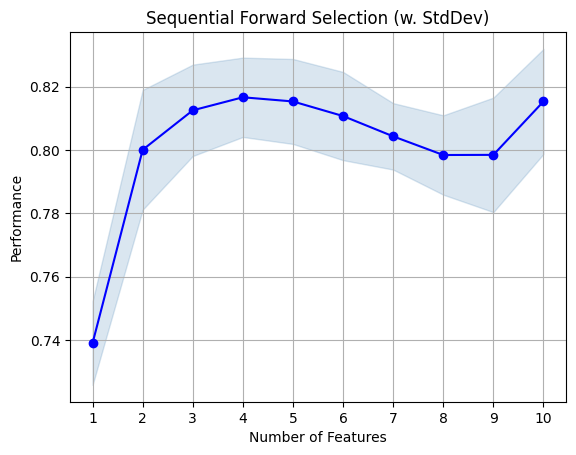

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig("fs_assets/sfs.png")

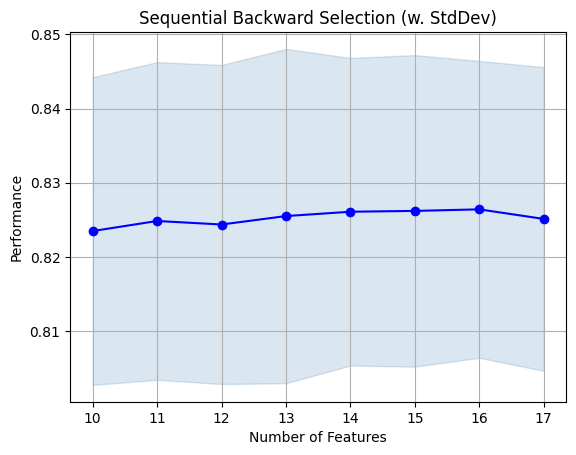

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig("fs_assets/sbs.png")

In [11]:
interc_features = list(set(top_sbs) & set(top_sfs))
union_features = union_features = list(set(top_sbs) | set(top_sfs))

In [18]:
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")


experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
   
    mlflow.log_artifacts("fs_assets/")

In [20]:
run_id

'41ed6b33da5442119f370a0ef2fa99fe'

In [21]:
X_train_interc = X_train[interc_features]
X_test_interc  = X_test[interc_features]

X_train_union = X_train[union_features]
X_test_union  = X_test[union_features]


In [22]:
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

def train_and_register(
    X_train, y_train,
    X_test, y_test,
    experiment_name,
    run_name,
    registered_model_name
):
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run(run_name=run_name) as run:
        model = CatBoostClassifier(
            iterations=300,
            depth=6,
            learning_rate=0.05,
            loss_function="Logloss",
            eval_metric="AUC",
            verbose=False,
            random_seed=42
        )

        model.fit(X_train, y_train)

        preds = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, preds)

        mlflow.log_metric("roc_auc", roc_auc)

        mlflow.catboost.log_model(
            model,
            artifact_path="model",
            registered_model_name=registered_model_name
        )

        return {
            "run_id": run.info.run_id,
            "roc_auc": roc_auc
        }


In [ ]:
interc_result = train_and_register(
    X_train_interc,
    y_train,
    X_test_interc,
    y_test,
    experiment_name="feature_selection_intersection",
    run_name="feature_selection_union",
    registered_model_name="feature_selection_union"
)

interc_result


Registered model 'feature_selection_union' already exists. Creating a new version of this model...
2026/02/10 20:59:15 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: feature_selection_union, version 4
Created version '4' of model 'feature_selection_union'.


{'run_id': '3f0330cf90824c86a2477f7fe6fca1b5', 'roc_auc': 0.8390833117025228}

In [32]:
union_result = train_and_register(
    X_train_union,
    y_train,
    X_test_union,
    y_test,
    experiment_name="feature_selection_union",
    run_name="feature_selection_union",
    registered_model_name="feature_selection_union"
)

union_result

Registered model 'feature_selection_union' already exists. Creating a new version of this model...
2026/02/10 20:59:18 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: feature_selection_union, version 5
Created version '5' of model 'feature_selection_union'.


{'run_id': '50f8c32443c940f48feaa253d93edbfc', 'roc_auc': 0.8392690821919901}